In [1]:
from utils import *

# Tobamovirus Classification Model: Results Analysis

This notebook provides a comprehensive analysis of the machine learning pipeline results for tobamovirus classification. The analysis covers three main components:

1. Model Selection: Comparison of different algorithms
2. Model Evaluation: Performance assessment using different contig prediction methods and optimizing threshold analysis for selected stacking method
3. Final Model: Feature importance analysis and model characteristics
4. **Gold Standard Analysis**: Evaluation on real data

In [2]:
gt = pd.read_excel('/home/tobamo/analize/project-tobamo/analysis/data/domain_sci_input/ground_truth_20250827.xlsx')
gt.columns = gt.columns.str.strip()
gt.rename(columns={'category': 'category_old'}, inplace=True)
gt['category'] = gt['category_old'].map({
    1: 'tob1',
    2: 'tob2',
    8: 'tob3',
    3: 'oth1',
    5: 'oth2',
    9: 'oth3',
    7: 'mas'
})

In [3]:
pr = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/snakemake/predictions/contig_predictions.csv')
merge = pd.merge(gt, pr, on='contig_name', how='inner')
merge.category.value_counts()

category
oth2    151
tob2    109
oth1    109
tob1     83
tob3     36
mas      22
Name: count, dtype: int64

In [4]:
df = merge.copy()
df['category'] = df['category'].astype(str)
df['prob_1'] = df['prob_1'].astype(float)
sorted_labels = sorted(df['category'].dropna().unique())

# Define the category palette
category_palette = {
    'tob1': "#006400",   # dark green
    'tob2': "#32CD32",   # lime green
    'tob3': "#2E8B57",   # sea green
    'oth1': "#FFA500",   # orange
    'oth2': "#F4A460",   # sandy brown
    'oth3': "#cd853f",   # peru
    'mas': "#7f7f7f",   # grey
}

# Define category descriptions
category_map = {
    'tob1': "Tobamoviral sequences - known",
    'tob2': "Tobamoviral sequences - novel",
    'tob3': "Tobamoviral sequences - difficult to assign",
    'oth1': "Sequences belonging/related to other members of Virgaviridae",
    'oth2': "Sequences belonging to other viruses",
    'oth3': "Sequences belonging to other viruses - difficult to assign",
    'mas': "Misassembled sequences"
}

In [5]:
# COMPREHENSIVE RESULTS ANALYSIS
# Analysis of model performance against ground truth using the df dataset

print("COMPREHENSIVE MODEL PERFORMANCE ANALYSIS")
print("="*70)

# Basic dataset information
print(f"\nDataset Overview:")
print(f"  Total contigs with ground truth: {len(df)}")
print(f"  Unique categories: {df['category'].nunique()}")
print(f"  Categories present: {sorted(df['category'].unique())}")

# Display category descriptions
print(f"\nCategory Descriptions:")
for cat in sorted(df['category'].unique()):
    if cat in category_map:
        print(f"  {cat}: {category_map[cat]}")
    else:
        print(f"  {cat}: Unknown category")

# Convert predictions to binary (tobamo vs non-tobamo)
tobamo_categories = ['tob1', 'tob2', 'tob3']
df['gt_binary'] = df['category'].apply(lambda x: 1 if x in tobamo_categories else 0)

print(f"\nBinary Ground Truth Classification:")
print(f"  Tobamo (categories tob1,tob2,tob3): {(df['gt_binary'] == 1).sum()} contigs")
print(f"  Non-tobamo (other categories): {(df['gt_binary'] == 0).sum()} contigs")

# Model performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

y_true = df['gt_binary']
y_pred = df['predicted_class']
y_prob = df['prob_1']

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nMODEL PERFORMANCE METRICS:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                 Non-T  Tobamo")
print(f"Actual Non-T     {cm[0,0]:5d}  {cm[0,1]:6d}")
print(f"       Tobamo    {cm[1,0]:5d}  {cm[1,1]:6d}")

# Performance by category
print(f"\nPERFORMANCE BY GROUND TRUTH CATEGORY:")
print("-" * 50)
for cat in sorted(df['category'].unique()):
    cat_data = df[df['category'] == cat]
    cat_accuracy = accuracy_score(cat_data['gt_binary'], cat_data['predicted_class'])
    cat_mean_prob = cat_data['prob_1'].mean()
    print(f"Category {cat} ({category_map.get(cat, 'Unknown')[:30]}):")
    print(f"  Count: {len(cat_data):3d}, Accuracy: {cat_accuracy:.3f}, Mean Prob: {cat_mean_prob:.3f}")

# Detailed classification report
print(f"\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_true, y_pred, target_names=['Non-tobamo', 'Tobamo']))

COMPREHENSIVE MODEL PERFORMANCE ANALYSIS

Dataset Overview:
  Total contigs with ground truth: 510
  Unique categories: 6
  Categories present: ['mas', 'oth1', 'oth2', 'tob1', 'tob2', 'tob3']

Category Descriptions:
  mas: Misassembled sequences
  oth1: Sequences belonging/related to other members of Virgaviridae
  oth2: Sequences belonging to other viruses
  tob1: Tobamoviral sequences - known
  tob2: Tobamoviral sequences - novel
  tob3: Tobamoviral sequences - difficult to assign

Binary Ground Truth Classification:
  Tobamo (categories tob1,tob2,tob3): 228 contigs
  Non-tobamo (other categories): 282 contigs

MODEL PERFORMANCE METRICS:
  Accuracy:  0.8255
  Precision: 0.7439
  Recall:    0.9298
  F1-Score:  0.8265

Confusion Matrix:
                 Predicted
                 Non-T  Tobamo
Actual Non-T       209      73
       Tobamo       16     212

PERFORMANCE BY GROUND TRUTH CATEGORY:
--------------------------------------------------
Category mas (Misassembled sequences):
  Co

VISUALIZATIONS

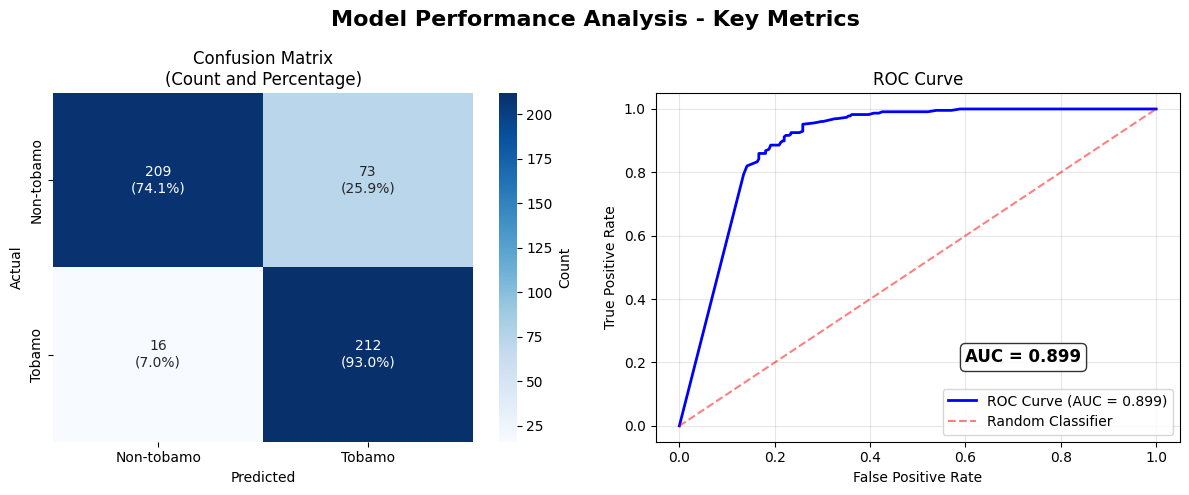

In [6]:
# COMPREHENSIVE VISUALIZATION PANEL
# Four key visualizations for model performance analysis

# First create the 2x2 subplot for confusion matrix and ROC curve
fig1, axes = plt.subplots(1, 2, figsize=(12, 5))
fig1.suptitle('Model Performance Analysis - Key Metrics', fontsize=16, fontweight='bold')

# 1. Confusion Matrix with percentages and actual numbers
ax1 = axes[0]
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create annotations with both counts and percentages
annotations = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annotations[i, j] = f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)'

sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', ax=ax1,
            xticklabels=['Non-tobamo', 'Tobamo'], 
            yticklabels=['Non-tobamo', 'Tobamo'],
            cbar_kws={'label': 'Count'})
ax1.set_title('Confusion Matrix\n(Count and Percentage)')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# 2. ROC Curve with AUC

# Calculate AUC
auc = roc_auc_score(df['gt_binary'], df['prob_1'])

ax2 = axes[1]
# Calculate ROC curve points
thresholds = np.linspace(0, 1, 101)
tpr_list, fpr_list = [], []
for threshold in thresholds:
    pred_thresh = (df['prob_1'] >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(df['gt_binary'], pred_thresh).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr_list.append(tpr)
    fpr_list.append(fpr)

ax2.plot(fpr_list, tpr_list, 'b-', linewidth=2, label=f'ROC Curve (AUC = {auc:.3f})')
ax2.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Random Classifier')
ax2.set_title('ROC Curve')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.text(0.6, 0.2, f'AUC = {auc:.3f}', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

Histograms for all vs false

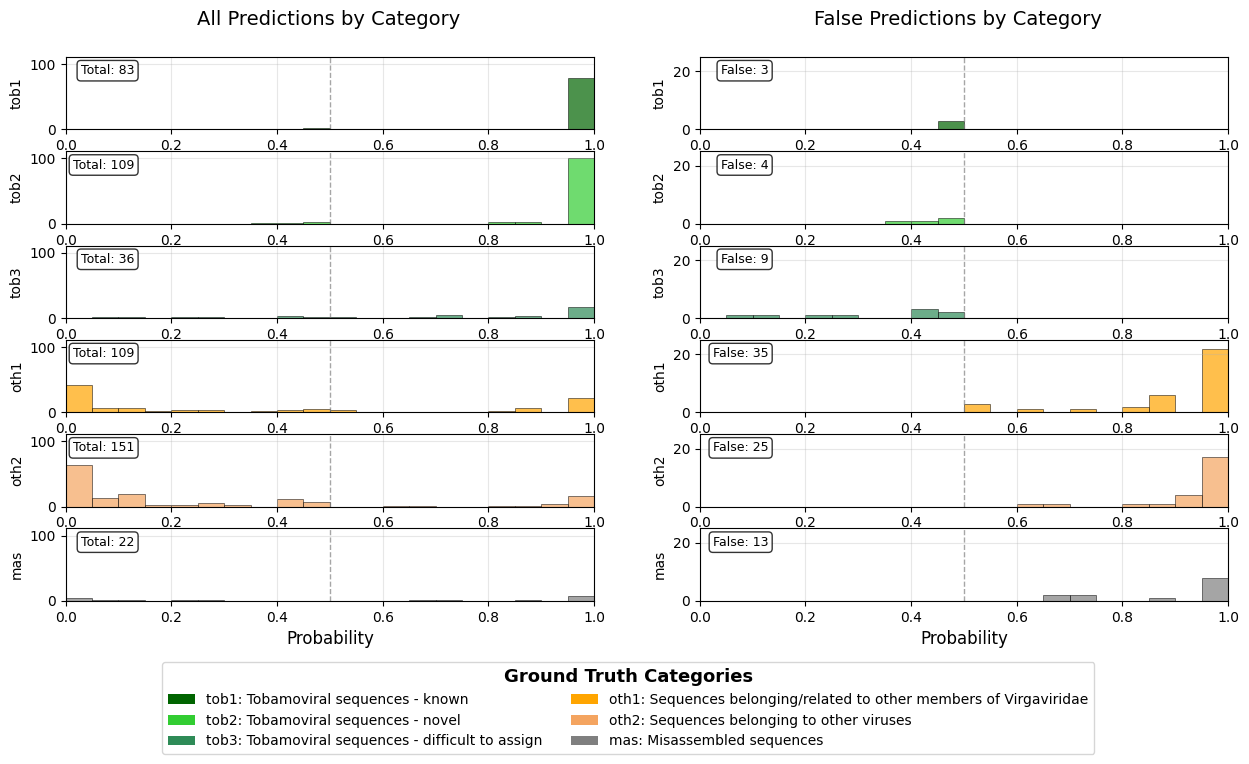

In [7]:
# 3 & 4. Create a figure with multiple subplots - histograms for all predictions vs false predictions by category
fig2 = plt.figure(figsize=(15, 8))

df_filtered = df.copy()
df_filtered['category'] = df_filtered['category'].astype(str)
df_filtered['prob_1'] = df_filtered['prob_1'].astype(float)

# Filter for false predictions only
false_predictions = df_filtered[df_filtered['gt_binary'] != df_filtered['predicted_class']]

# Define custom order for categories
custom_order = ['tob1', 'tob2', 'tob3', 'oth1', 'oth2', 'mas']
# Only include categories that exist in the data
ordered_labels = [cat for cat in custom_order if cat in df['category'].unique()]

# Create grid layout: 2 columns for histograms, rows for each category
gs = fig2.add_gridspec(len(ordered_labels), 2, width_ratios=[1, 1], hspace=0.3)

# Define bins for consistent bin width across all histograms
bin_width = 0.05  # 5% probability width per bin
bins = np.arange(0, 1 + bin_width, bin_width)  # Creates bins from 0 to 1 with fixed width

# LEFT PLOTS: Individual histograms for each category (all data)
# First, determine the maximum y-value across all left histograms for shared y-axis
max_y_left = 0
for category in ordered_labels:
    category_data = df_filtered[df_filtered['category'] == category]
    if len(category_data) > 0:
        counts, _ = np.histogram(category_data['prob_1'], bins=bins)
        max_y_left = max(max_y_left, counts.max())

# Add some padding to the max y value
max_y_left = int(max_y_left * 1.1) + 1

for i, category in enumerate(ordered_labels):
    ax_hist_left = fig2.add_subplot(gs[i, 0])
    
    # Get all data for this category
    category_data = df_filtered[df_filtered['category'] == category]
    
    if len(category_data) > 0:
        ax_hist_left.hist(category_data['prob_1'], bins=bins, alpha=0.7, 
                         color=category_palette[category], edgecolor='black', linewidth=0.5)
        
        # Add count text
        total_count = len(category_data)
        ax_hist_left.text(0.13, 0.90, f'Total: {total_count}', 
                         transform=ax_hist_left.transAxes, ha='right', va='top', 
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                         fontsize=9)
    else:
        # If no data, show empty plot
        ax_hist_left.text(0.5, 0.5, 'No data', 
                         transform=ax_hist_left.transAxes, ha='center', va='center',
                         fontsize=10, alpha=0.7)
    
    # Formatting for each left histogram
    ax_hist_left.set_xlim(0, 1)
    ax_hist_left.set_ylim(0, max_y_left)  # Set shared y-axis limits
    ax_hist_left.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=1)
    ax_hist_left.set_ylabel(f'{category}', fontsize=10)
    ax_hist_left.grid(True, alpha=0.3)
    
    # Only add x-label to bottom histogram
    if i == len(ordered_labels) - 1:
        ax_hist_left.set_xlabel('Probability', fontsize=12)
    else:
        ax_hist_left.set_xlabel('')

# RIGHT PLOTS: Individual histograms for each category (false predictions only)
# First, determine the maximum y-value across all right histograms for shared y-axis
max_y_right = 0
for category in ordered_labels:
    category_false_data = false_predictions[false_predictions['category'] == category]
    if len(category_false_data) > 0:
        counts, _ = np.histogram(category_false_data['prob_1'], bins=bins)
        max_y_right = max(max_y_right, counts.max())

# Add some padding to the max y value
max_y_right = int(max_y_right * 1.1) + 1

for i, category in enumerate(ordered_labels):
    ax_hist_right = fig2.add_subplot(gs[i, 1])
    
    # Get false predictions for this category
    category_false_data = false_predictions[false_predictions['category'] == category]
    
    if len(category_false_data) > 0:
        ax_hist_right.hist(category_false_data['prob_1'], bins=bins, alpha=0.7, 
                          color=category_palette[category], edgecolor='black', linewidth=0.5)
        
        # Add count text
        false_count = len(category_false_data)
        ax_hist_right.text(0.13, 0.90, f'False: {false_count}', 
                          transform=ax_hist_right.transAxes, ha='right', va='top', 
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                          fontsize=9)
    else:
        # If no false predictions, show empty plot
        ax_hist_right.text(0.5, 0.5, 'No false\npredictions', 
                          transform=ax_hist_right.transAxes, ha='center', va='center',
                          fontsize=10, alpha=0.7)
    
    # Formatting for each right histogram
    ax_hist_right.set_xlim(0, 1)
    ax_hist_right.set_ylim(0, max_y_right)  # Set shared y-axis limits
    ax_hist_right.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=1)
    ax_hist_right.set_ylabel(f'{category}', fontsize=10)
    ax_hist_right.grid(True, alpha=0.3)
    
    # Only add x-label to bottom histogram
    if i == len(ordered_labels) - 1:
        ax_hist_right.set_xlabel('Probability', fontsize=12)
    else:
        ax_hist_right.set_xlabel('')

# Add aligned main titles for both sections
fig2.text(0.3, 0.92, 'All Predictions by Category', fontsize=14, ha='center')
fig2.text(0.72, 0.92, 'False Predictions by Category', fontsize=14, ha='center')

# Create legend patches with category colors and descriptions
legend_handles = []
for cat in custom_order:  # Use custom order for legend
    if cat in df_filtered['category'].unique():
        patch = plt.Rectangle((0,0), 1, 1, fc=category_palette[cat])
        legend_handles.append((patch, f"{cat}: {category_map[cat]}"))

if legend_handles:
    patches, labels = zip(*legend_handles)
    
    # Add legend below the plots
    fig2.legend(
        patches, labels,
        loc='lower center',
        bbox_to_anchor=(0.5, 0),
        title="Ground Truth Categories",
        fontsize=10,
        ncol=2,
        title_fontproperties={'weight': 'bold', 'size': 13}
    )

# Adjust layout
# plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

Plot Ground Truth & Model Accuracy for each category

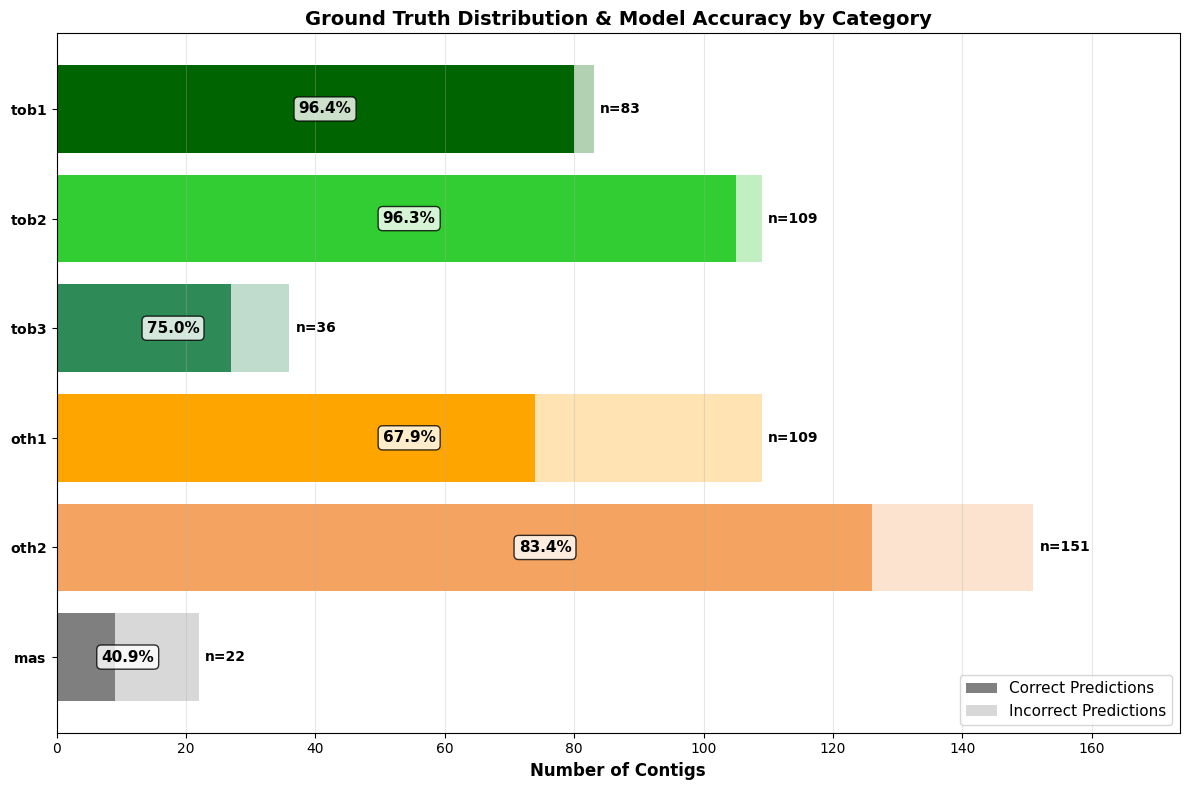


CATEGORY PERFORMANCE SUMMARY:
tob1:  83 contigs, 96.4% accuracy (80 correct, 3 incorrect)
tob2: 109 contigs, 96.3% accuracy (105 correct, 4 incorrect)
tob3:  36 contigs, 75.0% accuracy (27 correct, 9 incorrect)
oth1: 109 contigs, 67.9% accuracy (74 correct, 35 incorrect)
oth2: 151 contigs, 83.4% accuracy (126 correct, 25 incorrect)
mas:  22 contigs, 40.9% accuracy (9 correct, 13 incorrect)


In [8]:
# GROUND TRUTH DISTRIBUTION & MODEL ACCURACY BY CATEGORY
# Horizontal bar plot showing category counts and accuracy performance

# Calculate accuracy for each category
category_stats = []
for cat in custom_order:
    if cat in df['category'].unique():
        cat_data = df[df['category'] == cat]
        cat_count = len(cat_data)
        cat_accuracy = accuracy_score(cat_data['gt_binary'], cat_data['predicted_class'])
        correct_count = int(cat_count * cat_accuracy)
        incorrect_count = cat_count - correct_count
        
        category_stats.append({
            'category': cat,
            'total_count': cat_count,
            'correct_count': correct_count,
            'incorrect_count': incorrect_count,
            'accuracy': cat_accuracy
        })

# Convert to DataFrame for easier handling
cat_stats_df = pd.DataFrame(category_stats)

# Create the horizontal bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set up positions for bars
y_positions = np.arange(len(cat_stats_df))

# Create stacked horizontal bars using category colors
bars_correct = []
bars_incorrect = []
for i, (_, row) in enumerate(cat_stats_df.iterrows()):
    # Correct predictions with full opacity
    bar_correct = ax.barh(i, row['correct_count'], 
                         color=category_palette[row['category']], alpha=1.0)
    bars_correct.append(bar_correct)
    
    # Incorrect predictions with reduced opacity (same color)
    if row['incorrect_count'] > 0:
        bar_incorrect = ax.barh(i, row['incorrect_count'], 
                               left=row['correct_count'],
                               color=category_palette[row['category']], alpha=0.3)
        bars_incorrect.append(bar_incorrect)

# Create legend manually with correct colors
legend_elements = [
    plt.Rectangle((0,0),1,1, facecolor='gray', alpha=1.0, label='Correct Predictions'),
    plt.Rectangle((0,0),1,1, facecolor='gray', alpha=0.3, label='Incorrect Predictions')
]

# Customize the plot
ax.set_yticks(y_positions)
ax.set_yticklabels([f"$\\bf{{{row['category']}}}$" for _, row in cat_stats_df.iterrows()])
ax.set_xlabel('Number of Contigs', fontsize=12, fontweight='bold')
ax.set_title('Ground Truth Distribution & Model Accuracy by Category', 
             fontsize=14, fontweight='bold')

# Add text annotations with counts and accuracy percentages
for i, (_, row) in enumerate(cat_stats_df.iterrows()):
    # Total count at the end of the bar
    ax.text(row['total_count'] + 1, i, f"n={row['total_count']}", 
           va='center', ha='left', fontweight='bold', fontsize=10)
    
    # Accuracy percentage in the middle of the bar
    if row['total_count'] > 0:
        ax.text(row['total_count'] / 2, i, f"{row['accuracy']:.1%}", 
               va='center', ha='center', fontweight='bold', fontsize=11,
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Add legend
ax.legend(handles=legend_elements, loc='lower right', fontsize=11)

# Add grid for better readability
ax.grid(True, axis='x', alpha=0.3)

# Invert y-axis to have tob1 at the top as requested
ax.invert_yaxis()

# Set x-axis limit with some padding
max_count = cat_stats_df['total_count'].max()
ax.set_xlim(0, max_count * 1.15)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nCATEGORY PERFORMANCE SUMMARY:")
print("="*60)
for _, row in cat_stats_df.iterrows():
    print(f"{row['category']}: {row['total_count']:3d} contigs, "
          f"{row['accuracy']:.1%} accuracy "
          f"({row['correct_count']} correct, {row['incorrect_count']} incorrect)")

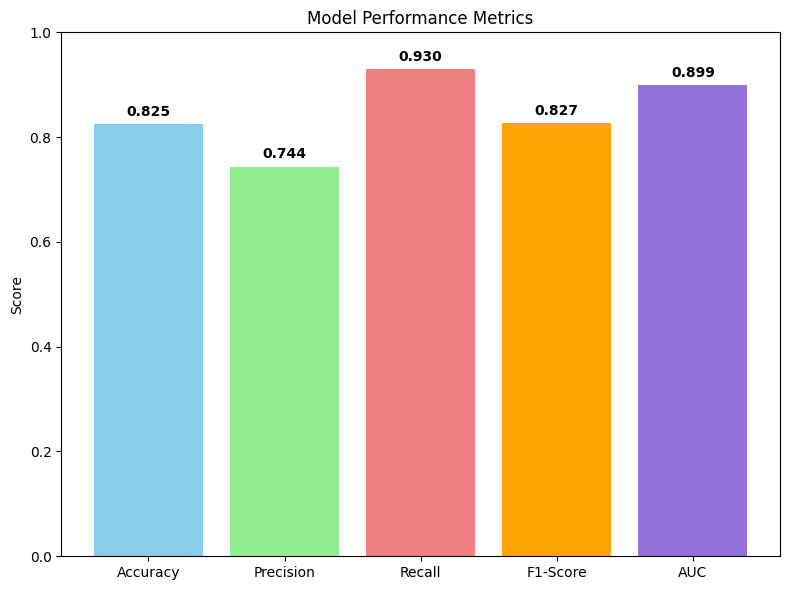

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
values = [accuracy, precision, recall, f1, auc]
bars = ax.bar(metrics, values, color=['skyblue', 'lightgreen', 'lightcoral', 'orange', 'mediumpurple'])
ax.set_title('Model Performance Metrics')
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
for bar, value in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

Let's make a panel!

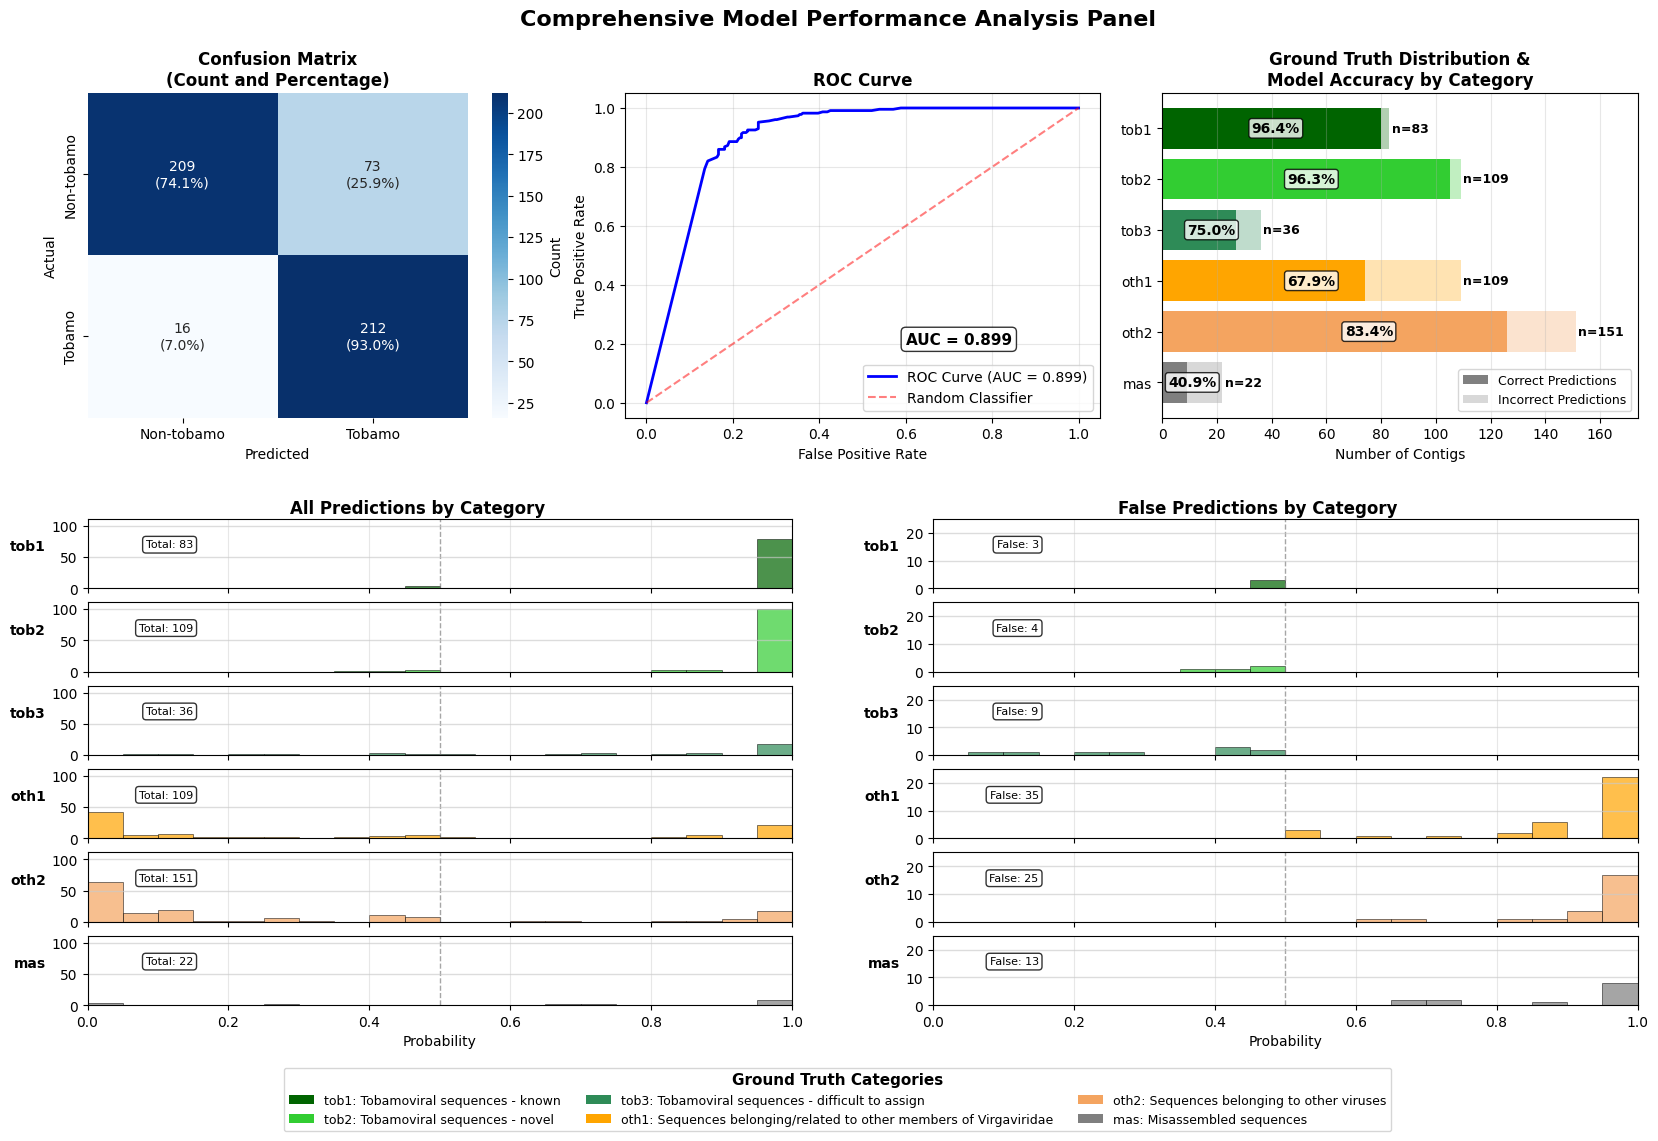

In [21]:
# COMPREHENSIVE VISUALIZATION PANEL
# Combine all key visualizations in a single figure with 2 rows
# Upper row: Confusion Matrix, ROC Curve, Ground Truth Distribution & Model Accuracy
# Lower row: Histograms for all predictions vs false predictions by category

fig = plt.figure(figsize=(20, 12))

# Create grid layout: 2 rows, 3 columns for upper row, full width for lower row
gs = fig.add_gridspec(2, 6, height_ratios=[1, 1.5], hspace=0.25, wspace=0.3)

# =============================================================================
# UPPER ROW - THREE MAIN PERFORMANCE VISUALIZATIONS
# =============================================================================

# 1. CONFUSION MATRIX (upper left)
ax1 = fig.add_subplot(gs[0, 0:2])
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
annotations = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annotations[i, j] = f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)'

sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', ax=ax1,
            xticklabels=['Non-tobamo', 'Tobamo'], 
            yticklabels=['Non-tobamo', 'Tobamo'],
            cbar_kws={'label': 'Count'})
ax1.set_title('Confusion Matrix\n(Count and Percentage)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# 2. ROC CURVE (upper middle)
ax2 = fig.add_subplot(gs[0, 2:4])
thresholds = np.linspace(0, 1, 101)
tpr_list, fpr_list = [], []
for threshold in thresholds:
    pred_thresh = (df['prob_1'] >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(df['gt_binary'], pred_thresh).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr_list.append(tpr)
    fpr_list.append(fpr)

ax2.plot(fpr_list, tpr_list, 'b-', linewidth=2, label=f'ROC Curve (AUC = {auc:.3f})')
ax2.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Random Classifier')
ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.text(0.6, 0.2, f'AUC = {auc:.3f}', fontsize=11, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 3. GROUND TRUTH DISTRIBUTION & MODEL ACCURACY (upper right)
ax3 = fig.add_subplot(gs[0, 4:6])
y_positions = np.arange(len(cat_stats_df))

for i, (_, row) in enumerate(cat_stats_df.iterrows()):
    # Correct predictions with full opacity
    ax3.barh(i, row['correct_count'], 
             color=category_palette[row['category']], alpha=1.0)
    
    # Incorrect predictions with reduced opacity
    if row['incorrect_count'] > 0:
        ax3.barh(i, row['incorrect_count'], 
                left=row['correct_count'],
                color=category_palette[row['category']], alpha=0.3)

ax3.set_yticks(y_positions)
ax3.set_yticklabels([f"{row['category']}" for _, row in cat_stats_df.iterrows()], rotation=0)
ax3.set_xlabel('Number of Contigs')
ax3.set_title('Ground Truth Distribution &\nModel Accuracy by Category', fontsize=12, fontweight='bold')

# Add text annotations
for i, (_, row) in enumerate(cat_stats_df.iterrows()):
    ax3.text(row['total_count'] + 1, i, f"n={row['total_count']}", 
            va='center', ha='left', fontweight='bold', fontsize=9)
    if row['total_count'] > 0:
        ax3.text(row['total_count'] / 2, i, f"{row['accuracy']:.1%}", 
                va='center', ha='center', fontweight='bold', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

ax3.grid(True, axis='x', alpha=0.3)
ax3.invert_yaxis()
max_count = cat_stats_df['total_count'].max()
ax3.set_xlim(0, max_count * 1.15)

# =============================================================================
# LOWER ROW - HISTOGRAM PANELS (all predictions vs false predictions)
# =============================================================================

# Filter data for histograms
df_filtered = df.copy()
df_filtered['category'] = df_filtered['category'].astype(str)
df_filtered['prob_1'] = df_filtered['prob_1'].astype(float)
false_predictions = df_filtered[df_filtered['gt_binary'] != df_filtered['predicted_class']]

# Define bins for consistent bin width across all histograms
bin_width = 0.05
bins = np.arange(0, 1 + bin_width, bin_width)

# Create subgrid for histograms (2 columns, multiple rows for categories)
gs_hist = gs[1, :].subgridspec(len(ordered_labels), 2, width_ratios=[1, 1], hspace=0.2)

# Calculate max y values for shared axes
max_y_left = 0
max_y_right = 0
for category in ordered_labels:
    category_data = df_filtered[df_filtered['category'] == category]
    category_false_data = false_predictions[false_predictions['category'] == category]
    
    if len(category_data) > 0:
        counts, _ = np.histogram(category_data['prob_1'], bins=bins)
        max_y_left = max(max_y_left, counts.max())
    
    if len(category_false_data) > 0:
        counts, _ = np.histogram(category_false_data['prob_1'], bins=bins)
        max_y_right = max(max_y_right, counts.max())

max_y_left = int(max_y_left * 1.1) + 1
max_y_right = int(max_y_right * 1.1) + 1

# LEFT HISTOGRAMS: All predictions by category
for i, category in enumerate(ordered_labels):
    ax_hist_left = fig.add_subplot(gs_hist[i, 0])
    
    category_data = df_filtered[df_filtered['category'] == category]
    
    if len(category_data) > 0:
        ax_hist_left.hist(category_data['prob_1'], bins=bins, alpha=0.7, 
                         color=category_palette[category], edgecolor='black', linewidth=0.5)
        total_count = len(category_data)
        ax_hist_left.text(0.15, 0.70, f'Total: {total_count}', 
                         transform=ax_hist_left.transAxes, ha='right', va='top', 
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                         fontsize=8)
    else:
        ax_hist_left.text(0.5, 0.5, 'No data', 
                         transform=ax_hist_left.transAxes, ha='center', va='center',
                         fontsize=9, alpha=0.7)
    
    ax_hist_left.set_xlim(0, 1)
    ax_hist_left.set_ylim(0, max_y_left)
    ax_hist_left.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=1)
    ax_hist_left.axhline(y=50, color='lightgray', linestyle='-', alpha=0.5, linewidth=1)
    ax_hist_left.axhline(y=100, color='lightgray', linestyle='-', alpha=0.5, linewidth=1)
    ax_hist_left.set_ylabel(f'{category}', fontsize=10, rotation=0, ha='right', fontweight='bold')
    
    # Set y-ticks to include horizontal line positions
    y_ticks = [0, 50, 100]
    ax_hist_left.set_yticks(y_ticks)
    ax_hist_left.tick_params(axis='y', labelsize=10)
    
    ax_hist_left.grid(True, alpha=0.3)
    
    if i == len(ordered_labels) - 1:
        ax_hist_left.set_xlabel('Probability', fontsize=10)
    else:
        ax_hist_left.set_xticklabels([])

# RIGHT HISTOGRAMS: False predictions by category
for i, category in enumerate(ordered_labels):
    ax_hist_right = fig.add_subplot(gs_hist[i, 1])
    
    category_false_data = false_predictions[false_predictions['category'] == category]
    
    if len(category_false_data) > 0:
        ax_hist_right.hist(category_false_data['prob_1'], bins=bins, alpha=0.7, 
                          color=category_palette[category], edgecolor='black', linewidth=0.5)
        false_count = len(category_false_data)
        ax_hist_right.text(0.15, 0.70, f'False: {false_count}', 
                          transform=ax_hist_right.transAxes, ha='right', va='top', 
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                          fontsize=8)
    else:
        ax_hist_right.text(0.5, 0.5, 'No false\npredictions', 
                          transform=ax_hist_right.transAxes, ha='center', va='center',
                          fontsize=9, alpha=0.7)
    
    ax_hist_right.set_xlim(0, 1)
    ax_hist_right.set_ylim(0, max_y_right)
    ax_hist_right.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=1)
    ax_hist_right.axhline(y=10, color='lightgray', linestyle='-', alpha=0.5, linewidth=1)
    ax_hist_right.axhline(y=20, color='lightgray', linestyle='-', alpha=0.5, linewidth=1)
    ax_hist_right.set_ylabel(f'{category}', fontsize=10, rotation=0, ha='right', fontweight='bold')
    
    # Set y-ticks to include horizontal line positions
    y_ticks = [0, 10, 20]
    ax_hist_right.set_yticks(y_ticks)
    ax_hist_right.tick_params(axis='y', labelsize=10)
    
    ax_hist_right.grid(True, alpha=0.3)
    
    if i == len(ordered_labels) - 1:
        ax_hist_right.set_xlabel('Probability', fontsize=10)
    else:
        ax_hist_right.set_xticklabels([])

# Add section titles for histogram panels
fig.text(0.29, 0.53, 'All Predictions by Category', fontsize=12, ha='center', fontweight='bold')
fig.text(0.71, 0.53, 'False Predictions by Category', fontsize=12, ha='center', fontweight='bold')

# Add overall title
fig.suptitle('Comprehensive Model Performance Analysis Panel', fontsize=16, fontweight='bold', y=0.95)

# Add legends for upper row plots
legend_elements_accuracy = [
    plt.Rectangle((0,0),1,1, facecolor='gray', alpha=1.0, label='Correct Predictions'),
    plt.Rectangle((0,0),1,1, facecolor='gray', alpha=0.3, label='Incorrect Predictions')
]
ax3.legend(handles=legend_elements_accuracy, loc='lower right', fontsize=9)

# Create main legend for categories at the bottom
legend_handles = []
for cat in custom_order:
    if cat in df_filtered['category'].unique():
        patch = plt.Rectangle((0,0), 1, 1, fc=category_palette[cat])
        legend_handles.append((patch, f"{cat}: {category_map[cat]}"))

if legend_handles:
    patches, labels = zip(*legend_handles)
    fig.legend(
        patches, labels,
        loc='lower center',
        bbox_to_anchor=(0.5, 0.01),
        title="Ground Truth Categories",
        fontsize=9,
        ncol=3,
        title_fontproperties={'weight': 'bold', 'size': 11}
    )

plt.subplots_adjust(bottom=0.12)
plt.show()

new panel

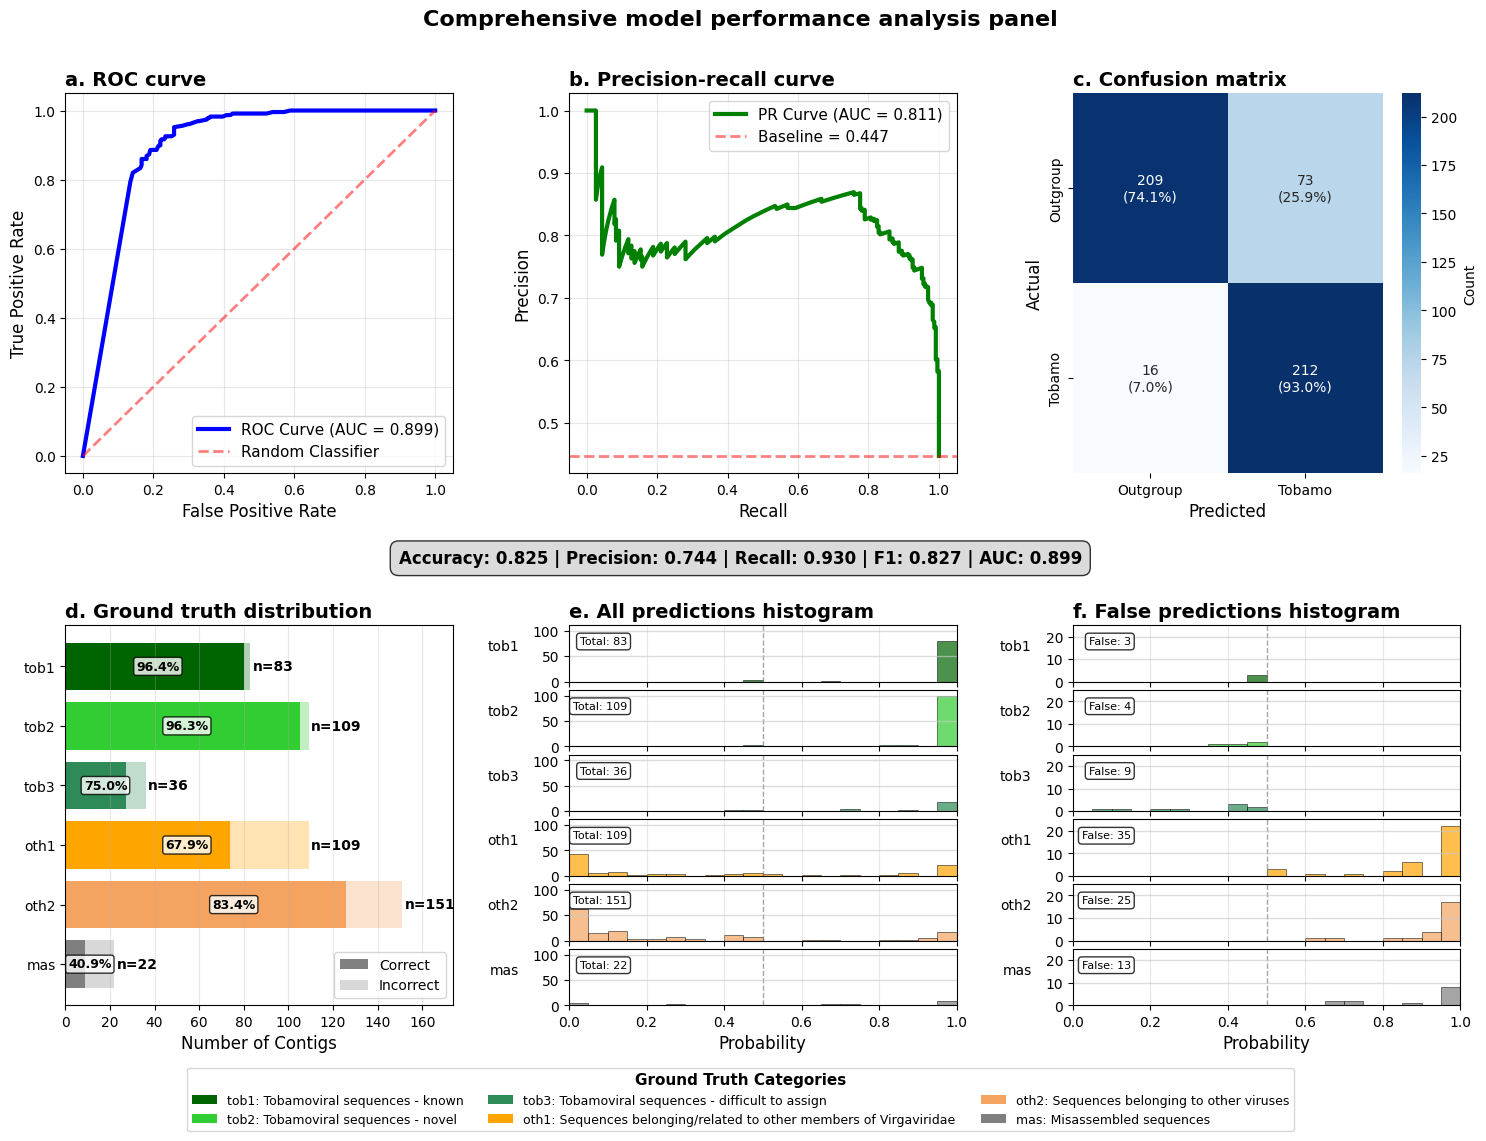

In [43]:
# NEW COMPREHENSIVE VISUALIZATION PANEL - 2x3 LAYOUT
# Upper row: ROC Curve, Precision-Recall Curve, Confusion Matrix
# Lower row: Ground Truth Distribution, All Predictions Histogram, False Predictions Histogram

from sklearn.metrics import precision_recall_curve, auc as calculate_auc

fig = plt.figure(figsize=(18, 12))

# Create grid layout: 2 rows, 3 columns
# Make both rows the same height
gs = fig.add_gridspec(2, 3, height_ratios=[1, 1], hspace=0.4, wspace=0.3)

# Set consistent tick label font size for all subplots
tick_fontsize = 10
tick_title_fontsize = 12

# =============================================================================
# UPPER ROW - PERFORMANCE CURVES AND CONFUSION MATRIX
# =============================================================================

# 1.A - ROC CURVE (upper left)
ax1 = fig.add_subplot(gs[0, 0])
thresholds = np.linspace(0, 1, 101)
tpr_list, fpr_list = [], []
for threshold in thresholds:
    pred_thresh = (df['prob_1'] >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(df['gt_binary'], pred_thresh).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr_list.append(tpr)
    fpr_list.append(fpr)

ax1.plot(fpr_list, tpr_list, 'b-', linewidth=3, label=f'ROC Curve (AUC = {auc:.3f})')
ax1.plot([0, 1], [0, 1], 'r--', alpha=0.5, linewidth=2, label='Random Classifier')
ax1.set_title('a. ROC curve', fontsize=14, fontweight='bold', loc='left')
ax1.set_xlabel('False Positive Rate', fontsize=tick_title_fontsize)
ax1.set_ylabel('True Positive Rate', fontsize=tick_title_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 1.B - PRECISION-RECALL CURVE (upper middle)
ax2 = fig.add_subplot(gs[0, 1])
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(df['gt_binary'], df['prob_1'])
pr_auc = calculate_auc(recall_vals, precision_vals)

ax2.plot(recall_vals, precision_vals, 'g-', linewidth=3, label=f'PR Curve (AUC = {pr_auc:.3f})')
# Add baseline (proportion of positive class)
baseline = df['gt_binary'].mean()
ax2.axhline(y=baseline, color='r', linestyle='--', alpha=0.5, linewidth=2, label=f'Baseline = {baseline:.3f}')
ax2.set_title('b. Precision-recall curve', fontsize=14, fontweight='bold', loc='left')
ax2.set_xlabel('Recall', fontsize=tick_title_fontsize)
ax2.set_ylabel('Precision', fontsize=tick_title_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# 1.C - CONFUSION MATRIX (upper right)
ax3 = fig.add_subplot(gs[0, 2])
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
annotations = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annotations[i, j] = f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)'

sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', ax=ax3,
            xticklabels=['Outgroup', 'Tobamo'], 
            yticklabels=['Outgroup', 'Tobamo'],
            cbar_kws={'label': 'Count'})
ax3.set_title('c. Confusion matrix', fontsize=14, fontweight='bold', loc='left')
ax3.set_xlabel('Predicted', fontsize=tick_title_fontsize)
ax3.set_ylabel('Actual', fontsize=tick_title_fontsize)
ax3.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# =============================================================================
# LOWER ROW - DISTRIBUTION ANALYSIS
# =============================================================================

# 2.A - GROUND TRUTH DISTRIBUTION & MODEL ACCURACY (lower left)
ax4 = fig.add_subplot(gs[1, 0])
y_positions = np.arange(len(cat_stats_df))

for i, (_, row) in enumerate(cat_stats_df.iterrows()):
    # Correct predictions with full opacity
    ax4.barh(i, row['correct_count'], 
             color=category_palette[row['category']], alpha=1.0)
    
    # Incorrect predictions with reduced opacity
    if row['incorrect_count'] > 0:
        ax4.barh(i, row['incorrect_count'], 
                left=row['correct_count'],
                color=category_palette[row['category']], alpha=0.3)

ax4.set_yticks(y_positions)
ax4.set_yticklabels([f"{row['category']}" for _, row in cat_stats_df.iterrows()], rotation=0)
ax4.set_xlabel('Number of Contigs', fontsize=tick_title_fontsize)
ax4.set_title('d. Ground truth distribution', fontsize=14, fontweight='bold', loc='left')
ax4.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Add text annotations
for i, (_, row) in enumerate(cat_stats_df.iterrows()):
    ax4.text(row['total_count'] + 1, i, f"n={row['total_count']}", 
            va='center', ha='left', fontweight='bold', fontsize=10)
    if row['total_count'] > 0:
        ax4.text(row['total_count'] / 2, i, f"{row['accuracy']:.1%}", 
                va='center', ha='center', fontweight='bold', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

# Add legend
legend_elements_accuracy = [
    plt.Rectangle((0,0),1,1, facecolor='gray', alpha=1.0, label='Correct'),
    plt.Rectangle((0,0),1,1, facecolor='gray', alpha=0.3, label='Incorrect')
]
ax4.legend(handles=legend_elements_accuracy, loc='lower right', fontsize=10)
ax4.grid(True, axis='x', alpha=0.3)
ax4.invert_yaxis()
max_count = cat_stats_df['total_count'].max()
ax4.set_xlim(0, max_count * 1.15)

# =============================================================================
# 2.B & 2.C - HISTOGRAM PANELS WITH INDIVIDUAL CATEGORY HISTOGRAMS
# =============================================================================

# Filter data for histograms
df_filtered = df.copy()
df_filtered['category'] = df_filtered['category'].astype(str)
df_filtered['prob_1'] = df_filtered['prob_1'].astype(float)
false_predictions = df_filtered[df_filtered['gt_binary'] != df_filtered['predicted_class']]

# Define bins for consistent bin width
bin_width = 0.05
bins = np.arange(0, 1 + bin_width, bin_width)

# Create subgrid for histograms in panels 2B and 2C
gs_hist_all = gs[1, 1].subgridspec(len(ordered_labels), 1, hspace=0.15)
gs_hist_false = gs[1, 2].subgridspec(len(ordered_labels), 1, hspace=0.15)

# Calculate max y values for shared axes
max_y_all = 0
max_y_false = 0
for category in ordered_labels:
    category_data = df_filtered[df_filtered['category'] == category]
    category_false_data = false_predictions[false_predictions['category'] == category]
    
    if len(category_data) > 0:
        counts, _ = np.histogram(category_data['prob_1'], bins=bins)
        max_y_all = max(max_y_all, counts.max())
    
    if len(category_false_data) > 0:
        counts, _ = np.histogram(category_false_data['prob_1'], bins=bins)
        max_y_false = max(max_y_false, counts.max())

max_y_all = int(max_y_all * 1.1) + 1
max_y_false = int(max_y_false * 1.1) + 1

# Define common y-positions for all subplots to ensure alignment
# Use the same indexing as cat_stats_df to match plot d
common_y_positions = {}
for i, (_, row) in enumerate(cat_stats_df.iterrows()):
    category = row['category']
    # Invert the position to match plot d (which is inverted)
    common_y_positions[category] = len(cat_stats_df) - 1 - i

# 2.B - ALL PREDICTIONS HISTOGRAMS BY CATEGORY
# Use the same order as cat_stats_df to ensure alignment with plot d
for plot_index, (_, cat_row) in enumerate(cat_stats_df.iterrows()):
    category = cat_row['category']
    ax_hist_all = fig.add_subplot(gs_hist_all[plot_index, 0])
    
    category_data = df_filtered[df_filtered['category'] == category]
    
    if len(category_data) > 0:
        ax_hist_all.hist(category_data['prob_1'], bins=bins, alpha=0.7, 
                        color=category_palette[category], edgecolor='black', linewidth=0.5)
        total_count = len(category_data)
        ax_hist_all.text(0.15, 0.80, f'Total: {total_count}', 
                        transform=ax_hist_all.transAxes, ha='right', va='top', 
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                        fontsize=8)
    else:
        ax_hist_all.text(0.5, 0.5, 'No data', 
                        transform=ax_hist_all.transAxes, ha='center', va='center',
                        fontsize=9, alpha=0.7)
    
    ax_hist_all.set_xlim(0, 1)
    ax_hist_all.set_ylim(0, max_y_all)
    ax_hist_all.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=1)
    ax_hist_all.axhline(y=50, color='lightgray', linestyle='-', alpha=0.5, linewidth=1)
    ax_hist_all.axhline(y=100, color='lightgray', linestyle='-', alpha=0.5, linewidth=1)
    ax_hist_all.set_ylabel(f'{category}', fontsize=10, rotation=0, ha='right', fontweight='normal', labelpad=10)
    ax_hist_all.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
    # Set y-ticks to include horizontal line positions
    y_ticks = [0, 50, 100]
    ax_hist_all.set_yticks(y_ticks)
    ax_hist_all.grid(True, alpha=0.3)
    
    # Only add x-label to bottom histogram
    if plot_index == len(cat_stats_df) - 1:
        ax_hist_all.set_xlabel('Probability', fontsize=tick_title_fontsize)
    else:
        ax_hist_all.set_xticklabels([])

# 2.C - FALSE PREDICTIONS HISTOGRAMS BY CATEGORY
# Use the same order as cat_stats_df to ensure alignment with plot d
for plot_index, (_, cat_row) in enumerate(cat_stats_df.iterrows()):
    category = cat_row['category']
    ax_hist_false = fig.add_subplot(gs_hist_false[plot_index, 0])
    
    category_false_data = false_predictions[false_predictions['category'] == category]
    
    if len(category_false_data) > 0:
        ax_hist_false.hist(category_false_data['prob_1'], bins=bins, alpha=0.7, 
                          color=category_palette[category], edgecolor='black', linewidth=0.5)
        false_count = len(category_false_data)
        ax_hist_false.text(0.15, 0.80, f'False: {false_count}', 
                          transform=ax_hist_false.transAxes, ha='right', va='top', 
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                          fontsize=8)
    else:
        ax_hist_false.text(0.5, 0.5, 'No false\npredictions', 
                          transform=ax_hist_false.transAxes, ha='center', va='center',
                          fontsize=9, alpha=0.7)
    
    ax_hist_false.set_xlim(0, 1)
    ax_hist_false.set_ylim(0, max_y_false)
    ax_hist_false.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=1)
    ax_hist_false.axhline(y=10, color='lightgray', linestyle='-', alpha=0.5, linewidth=1)
    ax_hist_false.axhline(y=20, color='lightgray', linestyle='-', alpha=0.5, linewidth=1)
    ax_hist_false.set_ylabel(f'{category}', fontsize=10, rotation=0, ha='right', fontweight='normal', labelpad=10)
    ax_hist_false.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
    # Set y-ticks to include horizontal line positions
    y_ticks = [0, 10, 20]
    ax_hist_false.set_yticks(y_ticks)
    ax_hist_false.grid(True, alpha=0.3)
    
    # Only add x-label to bottom histogram
    if plot_index == len(cat_stats_df) - 1:
        ax_hist_false.set_xlabel('Probability', fontsize=tick_title_fontsize)
    else:
        ax_hist_false.set_xticklabels([])

# Create invisible axes for titles to align them properly with the subplots
ax5_invisible = fig.add_subplot(gs[1, 1], frameon=False)
ax5_invisible.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
ax5_invisible.set_title('e. All predictions histogram', fontsize=14, fontweight='bold', loc='left')

ax6_invisible = fig.add_subplot(gs[1, 2], frameon=False)
ax6_invisible.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
ax6_invisible.set_title('f. False predictions histogram', fontsize=14, fontweight='bold', loc='left')

# Add overall title
fig.suptitle('Comprehensive model performance analysis panel', fontsize=16, fontweight='bold', y=0.95)

# Add performance metrics text
metrics_text = f"Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f} | AUC: {auc:.3f}"
fig.text(0.5, 0.485, metrics_text, ha='center', va='bottom', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

# Create main legend for categories at the bottom
legend_handles = []
for cat in custom_order:
    if cat in df_filtered['category'].unique():
        patch = plt.Rectangle((0,0), 1, 1, fc=category_palette[cat])
        legend_handles.append((patch, f"{cat}: {category_map[cat]}"))

if legend_handles:
    patches, labels = zip(*legend_handles)
    fig.legend(
        patches, labels,
        loc='lower center',
        bbox_to_anchor=(0.5, 0.01),
        title="Ground Truth Categories",
        fontsize=9,
        ncol=3,
        title_fontproperties={'weight': 'bold', 'size': 11}
    )

plt.subplots_adjust(bottom=0.12)
plt.show()

In [11]:
# FINAL SUMMARY AND RECOMMENDATIONS
print("\n" + "="*80)
print("FINAL SUMMARY AND RECOMMENDATIONS")
print("="*80)

print("\n🎯 MODEL PERFORMANCE SUMMARY:")
print("─" * 40)
print(f"• Overall Accuracy: {accuracy:.1%} - {'EXCELLENT' if accuracy > 0.85 else 'GOOD' if accuracy > 0.75 else 'MODERATE'}")
print(f"• Precision: {precision:.1%} - {precision:.0%} of predicted tobamo are actually tobamo")
print(f"• Recall: {recall:.1%} - {recall:.0%} of actual tobamo sequences are detected")
print(f"• F1-Score: {f1:.1%} - {'EXCELLENT' if f1 > 0.85 else 'GOOD' if f1 > 0.75 else 'MODERATE'}")
print(f"• AUC-ROC: {auc:.3f} - {'EXCELLENT' if auc > 0.90 else 'GOOD' if auc > 0.80 else 'MODERATE'} discriminative ability")

print(f"\n📊 KEY FINDINGS BY CATEGORY:")
print("─" * 40)
for _, row in cat_stats_df.iterrows():
    cat = row['category']
    acc = row['accuracy']
    count = row['total_count']
    status = "EXCELLENT" if acc > 0.95 else "GOOD" if acc > 0.85 else "MODERATE" if acc > 0.70 else "CHALLENGING"
    print(f"• {cat} ({category_map[cat][:40]}...): {acc:.1%} accuracy (n={count}) - {status}")

print(f"\n🔍 ERROR ANALYSIS:")
print("─" * 40)
false_pos_rate = cm[0,1]/(cm[0,0]+cm[0,1])
false_neg_rate = cm[1,0]/(cm[1,0]+cm[1,1])
total_errors = cm[0,1] + cm[1,0]
print(f"• Total misclassifications: {total_errors} out of {len(df)} samples ({total_errors/len(df):.1%})")
print(f"• False Positive Rate: {false_pos_rate:.1%} - Non-tobamo classified as tobamo")
print(f"• False Negative Rate: {false_neg_rate:.1%} - Tobamo sequences missed")

# Find most challenging categories
challenging_cats = cat_stats_df[cat_stats_df['accuracy'] < 0.85]['category'].tolist()
if challenging_cats:
    print(f"• Most challenging categories: {', '.join(challenging_cats)}")
else:
    print(f"• All categories show good performance (>85% accuracy)")

print(f"\n💡 RECOMMENDATIONS:")
print("─" * 40)
if accuracy > 0.85:
    print("1. 🟢 DEPLOYMENT READY: Model performance is excellent for production use")
else:
    print("1. 🟡 NEEDS IMPROVEMENT: Consider additional training or feature engineering")

if len(challenging_cats) > 0:
    print(f"2. 🟡 MONITOR CHALLENGING CATEGORIES: Pay special attention to {', '.join(challenging_cats)}")
else:
    print("2. 🟢 CONSISTENT PERFORMANCE: All categories show good accuracy")

if false_pos_rate > 0.15:
    print("3. 🟠 PRECISION FOCUS: Consider increasing threshold to reduce false positives")
elif false_neg_rate > 0.15:
    print("3. 🔵 RECALL FOCUS: Consider decreasing threshold to catch more tobamo sequences")
else:
    print("3. 🟢 BALANCED PERFORMANCE: Current threshold provides good precision-recall balance")

print("4. 🔍 UNCERTAINTY HANDLING: Flag cases with probabilities 0.4-0.6 for manual review")
print("5. 📊 REGULAR MONITORING: Track performance on new data to detect model drift")

if len(challenging_cats) > 0:
    print(f"6. 🔬 FEATURE ANALYSIS: Investigate features for improving {challenging_cats[0]} classification")

print(f"\n📈 OPTIMAL OPERATING POINTS:")
print("─" * 40)
print(f"• Current threshold (0.5): Precision={precision:.3f}, Recall={recall:.3f}")
if precision < recall:
    print("• Consider threshold ~0.6-0.7 for higher precision if false positives are costly")
else:
    print("• Consider threshold ~0.3-0.4 for higher recall if missing tobamo is costly")
print("• Current threshold provides good balance for most applications")

print(f"\n🎉 CONCLUSION:")
print("─" * 40)
if accuracy > 0.85 and f1 > 0.80:
    print("The tobamo virus detection model demonstrates EXCELLENT performance with:")
    print(f"• High accuracy ({accuracy:.1%}) across diverse sequence types")
    print(f"• Strong recall ({recall:.1%}) ensuring good detection of tobamo sequences")
    print(f"• Good precision ({precision:.1%}) with acceptable false positive rate")
    print(f"• Strong discriminative ability (AUC={auc:.3f})")
    print("\n✅ RECOMMENDATION: Model is ready for production deployment.")
elif accuracy > 0.75 and f1 > 0.70:
    print("The tobamo virus detection model demonstrates GOOD performance with:")
    print(f"• Good accuracy ({accuracy:.1%}) across most sequence types")
    print(f"• Reasonable balance between precision ({precision:.1%}) and recall ({recall:.1%})")
    print(f"• Acceptable discriminative ability (AUC={auc:.3f})")
    print("\n⚠️ RECOMMENDATION: Model can be deployed with careful monitoring.")
else:
    print("The tobamo virus detection model shows MODERATE performance:")
    print(f"• Accuracy ({accuracy:.1%}) may need improvement for production use")
    print(f"• Precision-recall balance needs optimization")
    print("\n🔧 RECOMMENDATION: Consider model improvement before deployment.")

if len(challenging_cats) > 0:
    print(f"\n⚠️ Special attention needed for: {', '.join(challenging_cats)} categories")


FINAL SUMMARY AND RECOMMENDATIONS

🎯 MODEL PERFORMANCE SUMMARY:
────────────────────────────────────────
• Overall Accuracy: 82.5% - GOOD
• Precision: 74.4% - 74% of predicted tobamo are actually tobamo
• Recall: 93.0% - 93% of actual tobamo sequences are detected
• F1-Score: 82.7% - GOOD
• AUC-ROC: 0.899 - GOOD discriminative ability

📊 KEY FINDINGS BY CATEGORY:
────────────────────────────────────────
• tob1 (Tobamoviral sequences - known...): 96.4% accuracy (n=83) - EXCELLENT
• tob2 (Tobamoviral sequences - novel...): 96.3% accuracy (n=109) - EXCELLENT
• tob3 (Tobamoviral sequences - difficult to ass...): 75.0% accuracy (n=36) - MODERATE
• oth1 (Sequences belonging/related to other mem...): 67.9% accuracy (n=109) - CHALLENGING
• oth2 (Sequences belonging to other viruses...): 83.4% accuracy (n=151) - MODERATE
• mas (Misassembled sequences...): 40.9% accuracy (n=22) - CHALLENGING

🔍 ERROR ANALYSIS:
────────────────────────────────────────
• Total misclassifications: 89 out of 510 sa